### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data Collection

In [3]:
data = pd.read_csv('diabetes_data.csv')

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# 1 -> Diabetic
# 0 -> Non-diabetic

### Data Preprocessing

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [8]:
data.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [9]:
X = data.drop('Outcome',axis = 1)
y = data['Outcome']

In [10]:
X.shape

(768, 8)

In [11]:
y.shape

(768,)

### Train_Test_Splits

In [12]:
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True)

In [13]:
x_train.shape

(614, 8)

In [14]:
y_train.shape

(614,)

In [15]:
x_test.shape

(154, 8)

In [16]:
y_test.shape

(154,)

### Models Training with GridSearchCV

In [17]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def gridsearchcv(X, y):
    algos = {
        'logistic_regression': {
            'model': LogisticRegression(max_iter=2000),
            'params': {
                'solver': ['liblinear', 'saga'],
                'penalty': ['l1', 'l2']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gscv = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gscv.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gscv.best_score_,
            'best_params': gscv.best_params_
        })
        best_estimator = gscv.best_estimator_
        pickle.dump(best_estimator, open(f'{algo_name}_model.p', 'wb'))

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [18]:
stats = gridsearchcv(x_train,y_train)

In [19]:
stats.to_csv('stats.csv')

In [20]:
stats

,model,best_score,best_params
0,logistic_regression,0.778862,"{'penalty': 'l1', 'solver': 'liblinear'}"


### Models Evaluation

#### Logistic Regression Model Evaluation

In [21]:
with open('logistic_regression_model.p', 'rb') as file:
    model = pickle.load(file)

In [22]:
model.score(x_train,y_train)

0.7785016286644951

In [23]:
model.score(x_test,y_test)

0.7662337662337663

Text(58.222222222222214, 0.5, 'Truth')

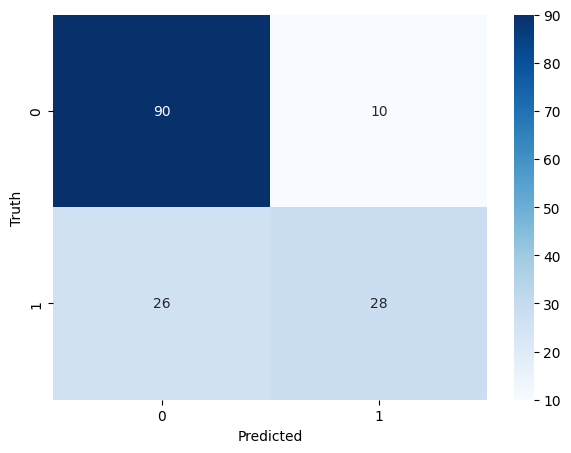

In [24]:
cm = confusion_matrix(y_test, model.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')